In [189]:
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8,5
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [190]:
filename = "data/films/tmdb_5000_{0}.csv"
movies = pd.read_csv(filename.format("movies"))
credits = pd.read_csv(filename.format("credits"))

In [191]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [192]:
movies["release_year"] = pd.to_datetime(movies['release_date'], format='%Y-%m-%d').dt.year.dropna().apply(int)

In [193]:
import json
from collections import Counter

def parse(s, key):
    try:
        d = json.loads(s)
        return d[0][key]
    except:
        return ""

def parse2list(s, key):
    try:
        dd = json.loads(s)
        if not isinstance(dd, list):
            dd = list(dd)
        return [d[key] for d in dd]
    except:
        return []

def top_N(column, N):
    res = column.apply(lambda s: parse2list(s, "name")).tolist()
    cnt = Counter([c for sub in res for c in sub])
    top = sorted([(v, k) for k, v in cnt.most_common()], reverse=True)[:min(N, len(cnt))]
    top = [v for k, v in top]
    return top

## 1. Сравнение количества выпущенных фильмов по годам для топовых студий

Найдем несколько топовых студий

In [194]:
top_companies = top_N(movies.production_companies, 7)
top_companies

['Warner Bros.',
 'Universal Pictures',
 'Paramount Pictures',
 'Twentieth Century Fox Film Corporation',
 'Columbia Pictures',
 'New Line Cinema',
 'Metro-Goldwyn-Mayer (MGM)']

Просуммируем фильмы по студиям и годам

In [195]:
for comp in top_companies:
    movies[comp] = movies.production_companies.apply(lambda s: comp in parse2list(s, "name"))
df1 = movies[top_companies + ["release_year"]].groupby("release_year").sum()
df1 = df1.iloc[df1.index > 1970]
df1.head()

,Warner Bros.,Universal Pictures,Paramount Pictures,Twentieth Century Fox Film Corporation,Columbia Pictures,New Line Cinema,Metro-Goldwyn-Mayer (MGM)
release_year,,,,,,,
1971.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0
1972.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0
1973.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0
1974.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0
1975.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


Простой stacked scatter график прекрасно показывает, что топовые студии придерживаются некой общей тенденции в количестве выпускаемых фильмов

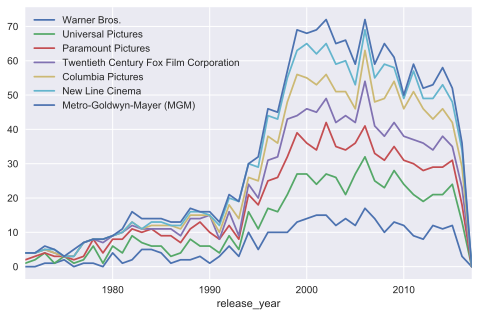

In [196]:
df1.plot(stacked=True)

## 2. Топовые жанры: распределение по странам

In [197]:
top_genres = top_N(movies.genres, 5)
top_genres

['Drama', 'Comedy', 'Thriller', 'Action', 'Romance']

In [198]:
top_countries = top_N(movies.production_countries, 6)[1:] # without USA
top_countries

['United Kingdom', 'Germany', 'France', 'Canada', 'Australia']

In [199]:
movies["lead_country"] = movies.production_countries.apply(\
    lambda s: parse(s, "name") if parse(s, "name") in top_countries else "Other")
for gen in top_genres:
    movies[gen] = movies.genres.apply(lambda s: gen in parse2list(s, "name"))
df2 = movies[top_genres + ["lead_country"]].groupby("lead_country").sum()
df2 = df2.drop("Other")
df2

,Drama,Comedy,Thriller,Action,Romance
lead_country,,,,,
Australia,30.0,28.0,23.0,29.0,12.0
Canada,102.0,60.0,75.0,57.0,26.0
France,94.0,43.0,59.0,46.0,32.0
Germany,105.0,69.0,79.0,63.0,31.0
United Kingdom,204.0,99.0,105.0,92.0,85.0


График хорошо совмещает в себе соотношение топовых жанров для каждой из лидирующих стран и объемы производства фильмов в целом. Видно, что соотношение жанров примерно одинаково для всех стран

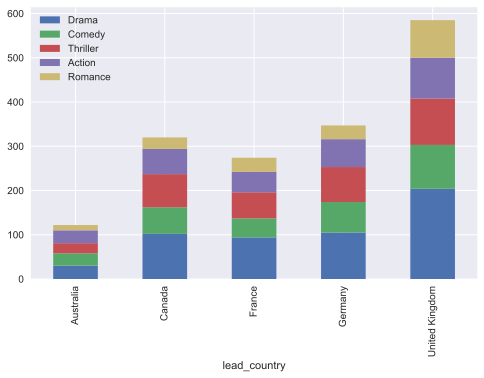

In [200]:
df2.plot(kind='bar', stacked=True)

## 3. Длительность фильма

In [201]:
import numpy as np

Для наглядности будем использовать логарифмическую шкалу по y

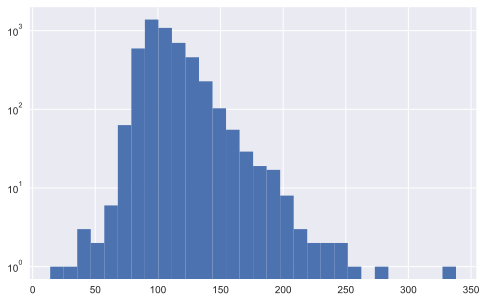

In [202]:
# visualize with y scaling
movies["runtime"] = movies.runtime.dropna()
plt.yscale('log', nonposy='clip')
plt.hist(runtime.loc[runtime > 0], bins=30);
#%config InlineBackend.figure_format = 'svg'
#sns.distplot(movies.runtime.dropna(), bins=20);

Попытки найти связь между длительностью и другими числовыми параметрами...

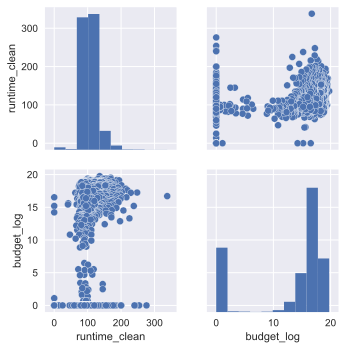

In [203]:
%config InlineBackend.figure_format = 'svg'
import math
movies["popularity_log"] = movies.popularity.dropna().apply(lambda x: np.log(x + 1))
movies["budget_log"] = movies.budget.dropna().apply(lambda x: np.log(x + 1))
movies["runtime_clean"] = movies.runtime.apply(lambda x: x if not math.isnan(x) else 0)
sns.pairplot(movies[["runtime_clean", "budget_log"]]);

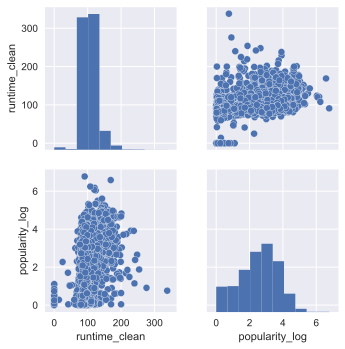

In [204]:
sns.pairplot(movies[["runtime_clean", "popularity_log"]]);

## 4. Окупаемость различных жанров

In [205]:
movies["lead_genre"] = movies.genres.apply(\
    lambda s: parse(s, "name") if parse(s, "name") in top_genres else "Other")

In [206]:
df4 = movies.groupby("lead_genre")[["budget", "revenue"]].mean()
df4["profit"] = (df4.revenue - df4.budget).apply(lambda x: x / 1e6)
df4 = df4.drop("Other")
df4

,budget,revenue,profit
lead_genre,,,
Action,4.765133e+07,1.218614e+08,74.210060
Comedy,1.883704e+07,5.178074e+07,32.943697
Drama,1.797940e+07,4.536260e+07,27.383197
Romance,2.053943e+07,6.575061e+07,45.211176
Thriller,2.469809e+07,6.048303e+07,35.784939


In [207]:
from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

На графике ниже сразу виден найболее окупаемый жанр, хотя и самый затратный - Action. Жанр Romance оказался вполне недорогим и даже более выгодным, чем триллер

In [208]:
trace0 = go.Scatter(
    x=df4.budget,
    y=df4.revenue,
    mode = 'markers+text',
    text = df4.index,
    marker = dict(
        size = df4.profit,
        color = [
            'aqua', 'azure', 'beige', 'lightgreen',
            'lavender', 'lightblue', 'pink'
        ]
    )
)

data = [trace0]
layout = {
    'title': 'Budget/Revenue for top genres',
    'xaxis': {'title': 'Budget'},
    'yaxis': {'title': 'Revenue'}
}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)